<a href="https://colab.research.google.com/github/Sajanm2058/Acoustic-Signal-Based-Binary-Classification-for-Brick-Wall-Inspection-by-Hammering-Test/blob/main/Dual_input_CNN_model_training__and_spectrogram_image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Define source folders
parent_folder = '/content/drive/MyDrive/Hammering_Test/s01'
g_hit_path = os.path.join(parent_folder, 'Good_result', 'G_hit')
b_hit_path = os.path.join(parent_folder, 'Bad_result', 'B_hit')
g_vib_path = os.path.join(parent_folder, 'Good_result', 'G_vib')
b_vib_path = os.path.join(parent_folder, 'Bad_result', 'B_vib')

# Define output spectrogram folder
spectrogram_root = '/content/drive/MyDrive/Hammering_Test/spectrograms'
paths = {
    'G_hit': g_hit_path,
    'B_hit': b_hit_path,
    'G_vib': g_vib_path,
    'B_vib': b_vib_path
}

def create_spectrogram(audio_path, save_path):
    y, sr = librosa.load(audio_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(3, 3))
    librosa.display.specshow(S_dB, sr=sr, x_axis=None, y_axis=None, cmap='viridis')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Process and save all spectrograms
for label, path in paths.items():
    output_dir = os.path.join(spectrogram_root, label)
    os.makedirs(output_dir, exist_ok=True)

    for file in tqdm(os.listdir(path), desc=f"Processing {label}"):
        if file.endswith('.wav'):
            input_path = os.path.join(path, file)
            output_path = os.path.join(output_dir, file.replace('.wav', '.png'))
            create_spectrogram(input_path, output_path)


Processing G_hit:   0%|          | 0/3111 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
Processing G_hit:   0%|          | 3/3111 [00:00<02:21, 21.93it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
Processing G_hit:   2%|▏         | 51/3111 [00:03<04:04, 12.54it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
Processing G_hit:   2%|▏         | 67/3111 [00:03<03:01, 16.76it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
Processing G_hit:   3%|▎         | 89/3111 [00:05<02:52, 17.56it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/sp

#🧠 CNN Classifier for Brick Quality

*🔧 Cell 1: Import Libraries*

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image

# Initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("✅ TPU initialized.")
except ValueError:
    print("❌ TPU not found. Using default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()


❌ TPU not found. Using default strategy (CPU/GPU).


In [ ]:
import tensorflow as tf

# Check if GPU is being used
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Device:", tf.test.gpu_device_name())

Num GPUs Available: 0
GPU Device: 


*📁 Cell 2: Define Paths and Labels*

In [ ]:
# Define base directory for spectrograms
base_dir = '/content/drive/MyDrive/Hammering_Test/spectrograms'

# Define mapping of folders to binary labels
classes = {
    'G_hit': 0,  # Good brick
    'G_vib': 0,  # Good brick
    'B_hit': 1,  # Bad brick
    'B_vib': 1   # Bad brick
}

*🖼️ Cell 3: Load Spectrogram Images and Labels*

In [ ]:
# Image size
img_size = (128, 128)

# Function to load and preprocess images
def load_images_and_labels(base_dir, class_map):
    images = []
    labels = []
    for class_name, label in class_map.items():
        class_path = os.path.join(base_dir, class_name)
        for file in os.listdir(class_path):
            if file.endswith('.png'):
                img_path = os.path.join(class_path, file)
                img = Image.open(img_path).convert('RGB').resize(img_size)
                images.append(np.array(img) / 255.0)  # Normalize pixel values
                labels.append(label)
    return np.array(images), np.array(labels)

X, y = load_images_and_labels(base_dir, classes)
print("Image data shape:", X.shape)
print("Label distribution:", np.bincount(y))


Image data shape: (12602, 128, 128, 3)
Label distribution: [6222 6380]


*🔀 Cell 4: Train-Test Split*

In [ ]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")


Training samples: 10081, Validation samples: 2521


*🧠 Cell 5: Define CNN Model*

In [ ]:
# CNN Architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # Binary output
])


*⚙️ Cell 6: Compile and Train the Model*

In [ ]:
# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 255s 800ms/step - accuracy: 0.7843 - loss: 0.4518 - val_accuracy: 0.8917 - val_loss: 0.2608
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 252s 796ms/step - accuracy: 0.8781 - loss: 0.2926 - val_accuracy: 0.9032 - val_loss: 0.2402
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 252s 796ms/step - accuracy: 0.8921 - loss: 0.2427 - val_accuracy: 0.9080 - val_loss: 0.2187
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 250s 789ms/step - accuracy: 0.9080 - loss: 0.2162 - val_accuracy: 0.9143 - val_loss: 0.1990
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 251s 793ms/step - accuracy: 0.9204 - loss: 0.1997 - val_accuracy: 0.9199 - val_loss: 0.1909
Epoch 6/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 250s 789ms/step - accuracy: 0.9237 - loss: 0.1886 - val_accuracy: 0.9234 - val_loss: 0.1628
Epoch 7/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 250s 791ms/step - accuracy: 0.9320 - loss: 0.1600 - val_accuracy: 0.9223 - val_loss: 0.1762
Epoch 8/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 249s 788ms/step - accuracy: 0.9356 -

*📊 Cell 7: Evaluate Model Performance*

In [ ]:
# Predict on validation set
val_preds = model.predict(X_val).ravel()
val_preds_class = (val_preds > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, val_preds_class, target_names=["Good", "Bad"]))

79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step

Classification Report:
              precision    recall  f1-score   support

        Good       0.91      0.96      0.94      1245
         Bad       0.96      0.91      0.93      1276

    accuracy                           0.94      2521
   macro avg       0.94      0.94      0.94      2521
weighted avg       0.94      0.94      0.94      2521



*🔍 Cell 8: Confusion Matrix*

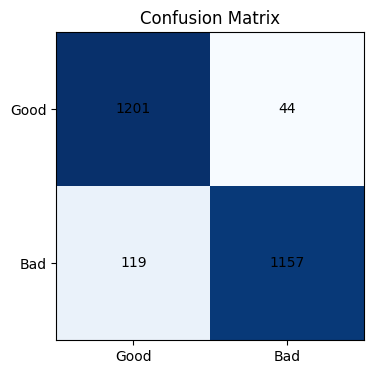

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_val, val_preds_class)
plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xticks([0, 1], ['Good', 'Bad'])
plt.yticks([0, 1], ['Good', 'Bad'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

*💾 Cell 9: Save Trained Model (Optional)*

In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/Hammering_Test/brick_quality_cnn_model.h5')

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.3 MB/s eta 0:00:00


#Two input CNN modelto process both hit and vibration spectrograms

*🔧 1. Imports and Setup*

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


*📂 2. Define Paths and Helper Function*

In [ ]:
import os
import numpy as np
from PIL import Image

base_dir = '/content/drive/MyDrive/Hammering_Test/spectrograms'
img_size = (128, 128)

# Mapping for folders
folders = {
    'G': 0,  # Good
    'B': 1   # Bad
}

# Load paired data (hit + vibration) and label
def load_paired_data():
    hit_images, vib_images, labels = [], [], []

    for label_name, label_val in folders.items():
        hit_folder = os.path.join(base_dir, f'{label_name}_hit')
        vib_folder = os.path.join(base_dir, f'{label_name}_vib')

        # Normalize and remove _hit/_vib suffixes to match
        hit_files = {f.replace('_hit', '').replace('.png', '').lower(): f for f in os.listdir(hit_folder) if f.endswith('.png')}
        vib_files = {f.replace('_vib', '').replace('.png', '').lower(): f for f in os.listdir(vib_folder) if f.endswith('.png')}

        common_keys = set(hit_files.keys()) & set(vib_files.keys())
        print(f"[{label_name}] Found {len(common_keys)} matching pairs.")

        for key in common_keys:
            hit_path = os.path.join(hit_folder, hit_files[key])
            vib_path = os.path.join(vib_folder, vib_files[key])

            try:
                hit_img = Image.open(hit_path).convert('RGB').resize(img_size)
                vib_img = Image.open(vib_path).convert('RGB').resize(img_size)

                hit_images.append(np.array(hit_img) / 255.0)
                vib_images.append(np.array(vib_img) / 255.0)
                labels.append(label_val)

            except Exception as e:
                print(f"Skipping {key} due to error:", e)

    return np.array(hit_images), np.array(vib_images), np.array(labels)

# Run and inspect output
X_hit, X_vib, y = load_paired_data()
print("Loaded:", X_hit.shape, X_vib.shape, y.shape)



*🔀 3. Train-Test Split*

In [ ]:
X_hit_train, X_hit_val, X_vib_train, X_vib_val, y_train, y_val = train_test_split(
    X_hit, X_vib, y, test_size=0.2, stratify=y, random_state=42)


*🧠 4. Define Dual-Input CNN Model*

In [ ]:
input_shape = (128, 128, 3)

# Input 1: Hit
hit_input = Input(shape=input_shape, name='hit_input')
x1 = layers.Conv2D(32, (3, 3), activation='relu')(hit_input)
x1 = layers.MaxPooling2D((2, 2))(x1)
x1 = layers.Conv2D(64, (3, 3), activation='relu')(x1)
x1 = layers.MaxPooling2D((2, 2))(x1)
x1 = layers.Conv2D(128, (3, 3), activation='relu')(x1)
x1 = layers.MaxPooling2D((2, 2))(x1)
x1 = layers.Flatten()(x1)

# Input 2: Vibration
vib_input = Input(shape=input_shape, name='vibration_input')
x2 = layers.Conv2D(32, (3, 3), activation='relu')(vib_input)
x2 = layers.MaxPooling2D((2, 2))(x2)
x2 = layers.Conv2D(64, (3, 3), activation='relu')(x2)
x2 = layers.MaxPooling2D((2, 2))(x2)
x2 = layers.Conv2D(128, (3, 3), activation='relu')(x2)
x2 = layers.MaxPooling2D((2, 2))(x2)
x2 = layers.Flatten()(x2)

# Combine branches
combined = layers.concatenate([x1, x2])
dense = layers.Dense(128, activation='relu')(combined)
dense = layers.Dropout(0.4)(dense)
output = layers.Dense(1, activation='sigmoid')(dense)

# Build Model
model = Model(inputs=[hit_input, vib_input], outputs=output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


*🚂 5. Train the Model*

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    {"hit_input": X_hit_train, "vibration_input": X_vib_train},
    y_train,
    validation_data=(
        {"hit_input": X_hit_val, "vibration_input": X_vib_val},
        y_val
    ),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)


*📊 6. Evaluate Performance*

In [ ]:
y_pred_probs = model.predict({"hit_input": X_hit_val, "vibration_input": X_vib_val}).ravel()
y_pred_classes = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes, target_names=["Good", "Bad"]))


40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 359ms/step

Classification Report:
              precision    recall  f1-score   support

        Good       0.97      0.97      0.97       623
         Bad       0.97      0.97      0.97       638

    accuracy                           0.97      1261
   macro avg       0.97      0.97      0.97      1261
weighted avg       0.97      0.97      0.97      1261



*🔍 7. Confusion Matrix*

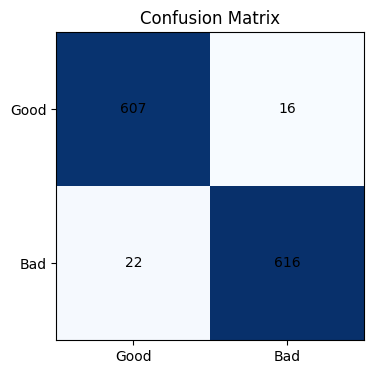

In [ ]:
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xticks([0, 1], ['Good', 'Bad'])
plt.yticks([0, 1], ['Good', 'Bad'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.show()


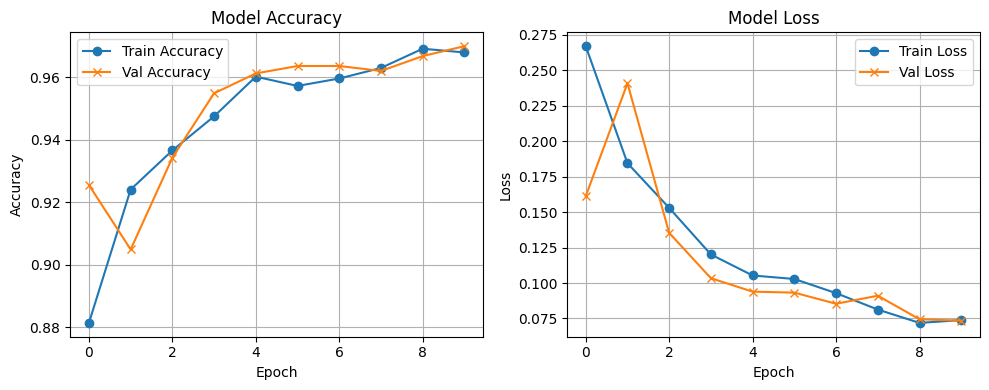

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


*💾 8. Save Model*

In [ ]:
model.save('/content/drive/MyDrive/Hammering_Test/dual_input_brick_classifier.h5')
